# Introduction on the real BACMMAN dataset

In [1]:
# mount drive
from google.colab import drive
ROOT = '/content/drive'     
drive.mount(ROOT, force_remount=True)
import os
os.chdir("/content/drive/My Drive/BACMMAN_DISTNET")

# install/load packages
!pip install git+https://github.com/jeanollion/dataset_iterator.git
# !pip install git+https://github.com/hugovaysset/uad.git
import tensorflow as tf
import h5py
import numpy as np
import matplotlib.pyplot as plt
from uad.models.variational_autoencoder import VAE  # package not found when install from github
from tensorflow.keras import layers, Model

# copy data locallly
dataset_dir = f"{ROOT}/My Drive/BACMMAN_DISTNET/data/BACMMAN/"
!cp "/content/drive/My Drive/BACMMAN_DISTNET/data/BACMMAN/train_val_eval.h5" "/home/train_val_eval.h5"
dataset_path = "/home/train_val_eval.h5"
print(dataset_path)

!nvidia-smi

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
  Cloning https://github.com/jeanollion/dataset_iterator.git to /tmp/pip-req-build-zonpi70e
  Running command git clone -q https://github.com/jeanollion/dataset_iterator.git /tmp/pip-req-build-zonpi70e
  Created wheel for dataset-iterator: filename=dataset_iterator-0.0.1-cp36-none-any.whl size=35945 sha256=f59aca8fb2667f33cb6071e7c97ddf3d1d920cbb34ac49b7155463dc2284a78c
  Stored in directory: /tmp/pip-ephem-wheel-cache-n98w6f0q/wheels/e1/b1/4a/efb8888afaa53e05

Using TensorFlow backend.


/home/train_val_eval.h5
Wed Jul 29 07:17:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                

## Load datasets

In [33]:
from dataset_iterator import MultiChannelIterator, PreProcessingImageGenerator

image_scaling = PreProcessingImageGenerator(lambda im:im/(2**8 - 1)) # 8 bits or 16 bits?

x_train = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "train", 
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators=[image_scaling],
                                batch_size=4
                                )

x_val = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "val",
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators=[image_scaling],
                                batch_size=4
                                )

x_test = MultiChannelIterator(dataset=dataset_path, 
                                channel_keywords=["/raw"],
                                group_keyword = "eval",
                                input_channels=[0],
                                output_channels=[0], 
                                image_data_generators=[image_scaling],
                                batch_size=64
                                )

print(f"Number of batches {len(x_train)} of size {len(x_train[0][0])}")

Number of batches 2467 of size 4


In [12]:
for i in range(1, 300):
    if 9868 % i == 0:
        print(i)

1
2
4


## Build model

In [14]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim1, dim2, dim3 = tf.shape(z_mean)[1], tf.shape(z_mean)[2], tf.shape(z_mean)[3]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim1, dim2, dim3))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


def conv2d_block(input_tensor, n_filters, kernel_size=(3, 1), batchnorm=True, activation1="relu",
                 activation2="sigmoid"):
    """Function to add 2 convolutional layers with the parameters passed to it
    activation1: name of the activation function to apply. If none, pass "" (empty string)
    activation2: name of the activation function to apply. If none, pass "" (empty string)
    """
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, 
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation1 != "":
        x = layers.Activation(activation1)(x)

    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=kernel_size, 
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation2 != "":
        x = layers.Activation(activation2)(x)

    return x


In [15]:
n_filters = 16
n_contractions = 5
latent_depth = n_filters * int(2**n_contractions)
latent_dims = (int(256 / (2**n_contractions)), int(32 / (2**n_contractions)), latent_depth)
batchnorm, dropout = False, 0.2
k_size = (3, 1)

encoder_inputs = layers.Input(shape=(256, 32, 1), name="encoder_inputs")

# contracting path
for i in range(n_contractions):
    if i == 0:
        x = conv2d_block(encoder_inputs, n_filters * 2**i, kernel_size=k_size, 
                         batchnorm=batchnorm)
    else:
        x = conv2d_block(x, n_filters * 2**i, kernel_size=k_size, batchnorm=batchnorm)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(dropout)(x)

z_mean = layers.Conv2D(latent_depth, 1, strides=1, name="z_mean")(x)
z_log_var = layers.Conv2D(latent_depth, 1, strides=1, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Define decoder model.
latent_inputs = layers.Input(shape=latent_dims, name="z_sampling")

for i in range(n_contractions - 1, 0, -1):
    if i == n_contractions - 1:
        x = layers.Conv2DTranspose(n_filters * 2**i, k_size, strides=(2, 2), 
                                   padding='same')(latent_inputs)
    else:
        x = layers.Conv2DTranspose(n_filters * 2**i, k_size, strides=(2, 2), 
                                   padding='same')(x)
    x = layers.Dropout(dropout)(x)
    x = conv2d_block(x, n_filters * 2**i, kernel_size=k_size, batchnorm=batchnorm)

x = layers.Conv2DTranspose(n_filters * 2**i, kernel_size=k_size, strides=(2, 2), 
                            padding='same')(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(1, kernel_size=k_size, padding="same")(x)


decoder = Model(inputs=latent_inputs, outputs=x, name="decoder")

In [16]:
class VAE(Model):
    """
    Variational autoencoder without predefined architecture. Build the encoder and decoder
    using the keras functional API and pass them as arguments to the class to instantiate
    a custom VAE model.
    """

    def __init__(self, encoder, decoder, dims=(28, 28, 1), reconstruction_loss="mse", **kwargs):
        """
        :param encoder:
        :param decoder:
        :param dims:
        :param reconstruction_loss: name of the reconstruction loss to use (can be "xent" for MNIST or "mse" for real
        images
        """
        super(VAE, self).__init__(**kwargs)
        self.dims = dims
        self.encoder = encoder
        self.decoder = decoder
        self.reconstruction_loss = reconstruction_loss

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:

            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            if self.reconstruction_loss == "xent":
                reconstruction_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(data, reconstruction)
                )
                reconstruction_loss *= self.dims[0] * self.dims[1]
            elif self.reconstruction_loss == "mse":
                reconstruction_loss = tf.keras.losses.MSE(data, reconstruction)
            else:
                raise NotImplementedError("Reconstruction loss should be either xent or mse")
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            if self.reconstruction_loss == "xent":
                reconstruction_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(data, reconstruction)
                )
                reconstruction_loss *= self.dims[0] * self.dims[1]
            elif self.reconstruction_loss == "mse":
                reconstruction_loss = tf.keras.losses.MSE(data, reconstruction)
            else:
                raise NotImplementedError("Reconstruction loss should be either xent or mse")
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

vae = VAE(encoder, decoder, dims=(256, 32, 1), reconstruction_loss="mse")

vae.compile(optimizer=tf.keras.optimizers.Adam())

In [35]:
epochs = 20
batch_size = 4

history = vae.fit(x_train, validation_data=x_val, epochs=epochs)

Epoch 1/20
2467/2467 [==============================] - 40s 16ms/step - loss: 1.6320 - reconstruction_loss: 1.6318 - kl_loss: 2.2584e-04 - val_loss: 1.4033 - val_reconstruction_loss: 1.4032 - val_kl_loss: 7.1688e-05
Epoch 2/20
2467/2467 [==============================] - 40s 16ms/step - loss: 1.4643 - reconstruction_loss: 1.4643 - kl_loss: 4.5511e-05 - val_loss: 1.1642 - val_reconstruction_loss: 1.1642 - val_kl_loss: 1.1227e-05
Epoch 3/20
2467/2467 [==============================] - 40s 16ms/step - loss: 1.4586 - reconstruction_loss: 1.4586 - kl_loss: 4.2102e-05 - val_loss: 1.8251 - val_reconstruction_loss: 1.8251 - val_kl_loss: 4.3037e-09
Epoch 4/20
2467/2467 [==============================] - 40s 16ms/step - loss: 1.4559 - reconstruction_loss: 1.4559 - kl_loss: 7.4976e-06 - val_loss: 1.7303 - val_reconstruction_loss: 1.7291 - val_kl_loss: 0.0011
Epoch 5/20
2467/2467 [==============================] - 39s 16ms/step - loss: 1.4537 - reconstruction_loss: 1.4536 - kl_loss: 6.3175e-05 - v

In [23]:
print(len(x_test))

30


In [36]:
z_means, zlv, _ = vae.encoder.predict(x_test)
predictions = vae.predict(x_test)

## Plot images and reconstructions

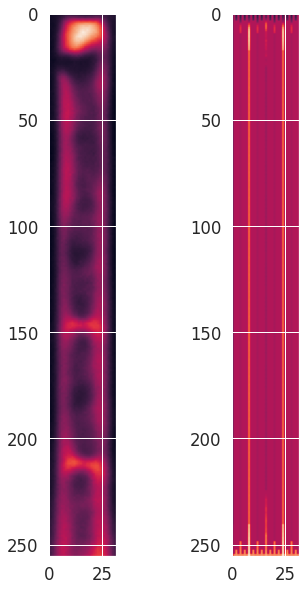

In [37]:
bat_len = 64
bat_idx = 0
idx = 1

fig, axes = plt.subplots(1, 2, figsize=(6, 10))

batch_x, batch_y = x_test[idx]
axes[0].imshow(np.squeeze(batch_x, -1)[0])
axes[1].imshow(np.squeeze(predictions[bat_len * bat_idx + idx], -1))
